# Collaboration and Competition

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the third project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from collections import deque
from torchsummary import summary
from unityagents import UnityEnvironment
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch

# MADDPG agent to be trained
from maddpg_agent import MADDPGAgent as Agent

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Tennis.app"`
- **Windows** (x86): `"path/to/Tennis_Windows_x86/Tennis.exe"`
- **Windows** (x86_64): `"path/to/Tennis_Windows_x86_64/Tennis.exe"`
- **Linux** (x86): `"path/to/Tennis_Linux/Tennis.x86"`
- **Linux** (x86_64): `"path/to/Tennis_Linux/Tennis.x86_64"`
- **Linux** (x86, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86"`
- **Linux** (x86_64, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86_64"`

For instance, if you are using a Mac, then you downloaded `Tennis.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Tennis.app")
```

In [2]:
env = UnityEnvironment(file_name="Tennis_Linux/Tennis.x86_64")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
print(env.brain_names)
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

['TennisBrain']


### 2. Examine the State and Action Spaces

In this environment, two agents control rackets to bounce a ball over a net. If an agent hits the ball over the net, it receives a reward of +0.1.  If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01.  Thus, the goal of each agent is to keep the ball in play.

The observation space consists of 8 variables corresponding to the position and velocity of the ball and racket. Two continuous actions are available, corresponding to movement toward (or away from) the net, and jumping. 

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


### 3. Take Random Actions in the Environment

The next cell shows how to use the Python API to control the agent and receive feedback from the environment.

Once this cell is executed, you will watch the agent's performance, if it selects an action (uniformly) at random with each time step.  A window should pop up that allows you to observe the agent, as it moves through the environment.  

In [5]:
for i in range(1, 6):                                      # play game for 5 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    print(scores)
    print('Score (max over agents) from episode {}: {}'.format(i, np.max(scores)))

### 4. Training the MADDPG Agent

When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```

In [6]:
def run_episode(agent, train_mode=False, if_train_then_step=True):
    """Runs a single episode of the environment.

    Params
    ======
        agent (Agent): agent object to be trained
        train_mode (bool): train_mode to be passed to the environment
        if_train_then_step (bool): indicates if agent should be trained when train_mode=True
    """  
    env_info = env.reset(train_mode=train_mode)[brain_name]# reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    i = 0
    while True:
        i += 1
        actions = agent.act(states, noise=train_mode)      # select an action (for each agent)
        # print(actions)
        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        env_info = env.step(actions)[brain_name]           # send all actions to the environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        if train_mode and if_train_then_step:
            agent.step(states, actions, rewards, next_states, dones)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    max_score = np.max(scores)
    return max_score, i

In [7]:
def maddpg(agent, max_episodes=3000, checkpoint_each=500, print_each=100,
         solve_window_size=100, solve_score=0.5):
    """Trains a MADDPG agent.

    Params
    ======
        agent (Agent): agent object to be trained
        max_episodes (int): max number of episodes
        checkpoint_each (int): number of episodes to skip before checkpointing model 
        print_each (int): number of episodes to skip before printing current score
        solve_window_size (int): number of consecutive episodes to consider the environment solved
        solve_score (int): minimum average score to reach after solve_window_size
    """
    idx_episode = 0
    scores = []
    scores_window = deque(maxlen=solve_window_size)
    try:
        for i in range(1, max_episodes+1):
            idx_episode += 1
            state = env.reset()
            agent.reset()

            score, episode_len = run_episode(agent, train_mode=True)
            scores.append(score)
            scores_window.append(score)

            avg_score = np.mean(scores_window)
            end = '\n' if (i%print_each == 0 or avg_score >= solve_score) else ''
            print("\rEpisode #{:3d}  |  "
                  "Score: {:+6.2f}  |  "
                  "Avg. Score: {:+6.2f}  |  "
                  "Episode length: {}".format(i, score, avg_score, episode_len),
                  end=end
            )
            if i%checkpoint_each == 0:
                agent.save_model(prefix_name='checkpoint')
                print('Checkpoint saved!')
            if avg_score >= solve_score and i >= solve_window_size:
                print('Environment solved in {} episodes!'.format(i))
                break
    except KeyboardInterrupt:
        print('Interrupted in episode {}'.format(idx_episode))
    # save model after all episodes
    agent.save_model()
    print('Model saved!')
    
    if np.mean(scores_window) < solve_score:
        print('Agent could not solve the environment in {} episodes'.format(idx_episode))
    
    return scores

In [8]:
agent = Agent(n_agents=num_agents, state_size=state_size, action_size=action_size, seed=0)
print('Agent actor network architecture:')
summary(agent.maddpg_agent[0].actor, (state_size, ))

Agent actor network architecture:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 400]          10,000
       BatchNorm1d-2                  [-1, 400]             800
              ReLU-3                  [-1, 400]               0
            Linear-4                  [-1, 300]         120,300
       BatchNorm1d-5                  [-1, 300]             600
              ReLU-6                  [-1, 300]               0
            Linear-7                    [-1, 2]             602
Total params: 132,302
Trainable params: 132,302
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 0.50
Estimated Total Size (MB): 0.52
----------------------------------------------------------------


In [9]:
print('Agent critic network architecture:')
summary(agent.maddpg_agent[0].critic, [(num_agents*state_size,), (num_agents*action_size,)])

Agent critic network architecture:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 400]          19,600
       BatchNorm1d-2                  [-1, 400]             800
              ReLU-3                  [-1, 400]               0
            Linear-4                  [-1, 300]         121,500
       BatchNorm1d-5                  [-1, 300]             600
              ReLU-6                  [-1, 300]               0
            Linear-7                    [-1, 1]             301
Total params: 142,801
Trainable params: 142,801
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 0.54
Estimated Total Size (MB): 0.56
----------------------------------------------------------------


In [10]:
all_scores = []
max_episodes = 3000
print_each = 50
solve_score = 0.5
solve_window_size = 100

In [11]:
%%time
scores = maddpg(agent, max_episodes=max_episodes, print_each=print_each,
              solve_window_size=solve_window_size, solve_score=solve_score)
all_scores += scores

Episode # 50  |  Score:  +0.00  |  Avg. Score:  +0.02  |  Episode length: 14
Episode #100  |  Score:  +0.00  |  Avg. Score:  +0.03  |  Episode length: 14
Episode #150  |  Score:  +0.00  |  Avg. Score:  +0.03  |  Episode length: 15
Episode #200  |  Score:  +0.00  |  Avg. Score:  +0.02  |  Episode length: 15
Episode #250  |  Score:  +0.00  |  Avg. Score:  +0.01  |  Episode length: 14
Episode #300  |  Score:  +0.00  |  Avg. Score:  +0.01  |  Episode length: 14
Episode #350  |  Score:  +0.00  |  Avg. Score:  +0.03  |  Episode length: 14
Episode #400  |  Score:  +0.10  |  Avg. Score:  +0.04  |  Episode length: 32
Episode #450  |  Score:  +0.00  |  Avg. Score:  +0.03  |  Episode length: 14
Episode #500  |  Score:  +0.10  |  Avg. Score:  +0.03  |  Episode length: 30
Checkpoint saved!
Episode #550  |  Score:  +0.10  |  Avg. Score:  +0.03  |  Episode length: 31
Episode #600  |  Score:  +0.10  |  Avg. Score:  +0.04  |  Episode length: 31
Episode #650  |  Score:  +0.00  |  Avg. Score:  +0.05  |  

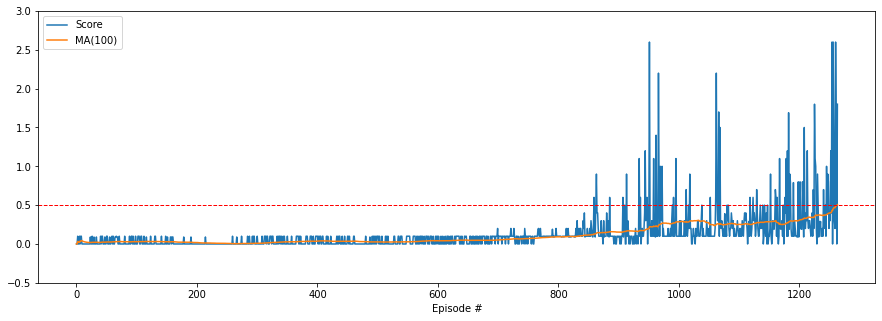

In [12]:
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(all_scores, label='Score')
pd.Series(all_scores).rolling(100, 1).mean().plot(ax=ax, label='MA(100)')
ax.axhline(solve_score, ls='--', lw=1, c='red')
ax.set_xlabel('Episode #')
ax.set_yticks(list(set(list(plt.yticks()[0]) + [solve_score])))
ax.legend(loc='upper left');

### 5. Loading and executing MADDPG Agent

As the model weights are saved, we can load them into a new agent.

In [13]:
trained_agent = Agent(n_agents=num_agents, state_size=state_size, action_size=action_size, seed=0)
trained_agent.load_model()

In [14]:
run_episode(trained_agent)

(2.600000038743019, 1001)

When finished, you can close the environment.

In [15]:
env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```